In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from sklearn.impute import SimpleImputer

In [9]:
df=pd.read_csv("Dataset.csv")  

df['DATE']=pd.to_datetime(df['DATE'])

df['DATE'] = pd.to_datetime(df.DATE) + pd.offsets.MonthBegin(0)
for index in range(len(df['DATE'])-1, 1,-1):
    if df['DATE'][index] == df['DATE'][index-1]:
        df.iloc[index-1,2]+=df['ORDER_QTY'][index]
        df.drop(index, inplace=True)

tmax=df['DATE'].max()
tmin=df['DATE'].min()
ts_fixed=pd.date_range(tmin,tmax,freq='MS', closed='right')

df.set_index('DATE', inplace=True)

df3=pd.DataFrame(columns=df.columns)
for i in set(df['CUST_ID']):
    temp=df[df['CUST_ID']==i].reindex(index=ts_fixed)
    temp['CUST_ID'].fillna(i, inplace=True)
    temp['ORDER_QTY'].fillna(0, inplace=True)
    temp['PRICE_USD'].fillna(method='ffill', inplace=True)
    temp['PRICE_USD'].fillna(method='bfill', inplace=True)
    df3=df3.append(temp)

df4=pd.concat([df3.pivot(columns='CUST_ID', values='ORDER_QTY'),
               df3.pivot(columns='CUST_ID', values='PRICE_USD')], axis=1
             )
df4.columns=[str(x)+ '_QTY' for x in range(100)]+[str(x)+'_PRICE' for x in range(100)]


In [10]:
scaler=RobustScaler(with_centering=False,quantile_range=(5,95))

scaler=scaler.fit(df4)

df_scaled=scaler.transform(df4)

In [11]:
#train_size = int(0.7 * len(df_scaled))
#train_scaled=df_scaled
#test_scaled=df_scaled[train_size:]

In [12]:
n_future=1
n_past=6
trainX, trainY=[],[]

In [13]:
for i in range(n_past, len(df_scaled)-n_future+1):
    trainX.append(df_scaled[i-n_past:i, 0:df_scaled.shape[1]])
    trainY.append(df_scaled[(i+n_future-1):(i+n_future),0:100])
trainX, trainY= np.array(trainX), np.array(trainY)    

In [14]:
# for i in range(n_past, len(test_scaled)-n_future+1):
#     testX.append(test_scaled[i-n_past:i, 0:test_scaled.shape[1]])
#     testY.append(test_scaled[i+n_future-1:i+n_future,0:100])
# testX, testY= np.array(testX), np.array(testY)


In [15]:
model=Sequential()

model.add(LSTM(10000, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), 
               return_sequences=True))
model.add(LSTM(4000, activation='relu', return_sequences=False))
#model.add(LSTM(8000, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), 
#               return_sequences=False))
model.add(Dropout(0.2))
#model.add(Dense(trainY.shape[2], activation='sigmoid'))
model.add(Dense(100))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history=model.fit(trainX, trainY[:,:,0], epochs=50, validation_split=0.2, verbose=1)

In [33]:
n_future=1

In [35]:
forecast_dates=pd.date_range(list(df4.index)[-1], periods=n_future, freq='MS').tolist()

In [37]:
forecast=model.predict(trainX[-n_future:])

forecast_copies=np.repeat(forecast, 2, axis=-1)
y_pred_future=scaler.inverse_transform(forecast_copies)[:,0:99]

forecast_index=[]
for time_i in forecast_dates:
    forecast_index.append(time_i.date())

Exception: Data must be 1-dimensional

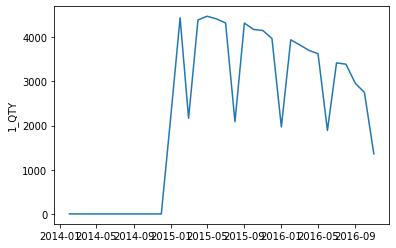

In [54]:
sns.lineplot(df4.index,df4['1_QTY'] )
sns.lineplot(forecast_index, y_pred_future[:,1])

In [69]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(y_pred_future, df4.iloc[-n_future:, 0:99])
print("Mean_squared_error is ", mse)

Mean_squared_error is  24990739.797399394


In [119]:
normalize3=df4.iloc[-2:-1,:]
normalize3.iloc[:,100:200]=3
prediction_scaled=scaler.transform(normalize3)
temp=trainX[-n_future:].copy()
temp[:,:,100:200]=prediction_scaled[:,100:200]


D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [147]:
forecast_3=model.predict(temp)

forecast_3_copies=np.repeat(forecast_3, 2, axis=-1)

pred_future_3=scaler.inverse_transform(forecast_3_copies)

pred_future_3[0,100:200]=3.0

In [189]:
df=pd.read_csv("Dataset.csv")  
res=pd.DataFrame(columns=df.columns)
for index, i in enumerate(pred_future_3[0,0:100]):
    res=res.append(pd.DataFrame([[index, forecast_index[1], int(i),3.0]], columns=df.columns))

In [193]:
res.to_csv('Prediction.csv', index=False)